In [1]:
import urllib3
import json
import requests
import pandas as pd
from ggplot import *
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from datetime import timedelta

%matplotlib inline


/Users/mdclark/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/mdclark/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/mdclark/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
apikey = open('api.txt').readlines()[0]

state='CA'
city='Palo_Alto'


yesterday_URL='http://api.wunderground.com/api/' + apikey + '/yesterday/q/' + state + '/' + city + '.json'

forecast_URL='http://api.wunderground.com/api/' + apikey + '/hourly/q/' + state + '/' + city + '.json'
today_URL='http://api.wunderground.com/api/' + apikey + '/history_' + datetime.date.today().strftime('%Y%m%d') + '/q/' + state + '/' + city + '.json'



forecast_data = requests.get(forecast_URL).json()
yesterday_data = requests.get(yesterday_URL).json()

today_data = requests.get(today_URL).json()
tomorrow_data = requests.get(yesterday_URL).json()

In [3]:
current_day = int(datetime.date.today().strftime('%d'))
yesterday_day = int((datetime.datetime.now() - timedelta(days=1)).strftime('%d'))
tomorrow_day = int((datetime.datetime.now() + timedelta(days=1)).strftime('%d'))

current_hour = datetime.datetime.now().hour
current_minute = datetime.datetime.now().minute / 60



In [4]:
forecast = pd.DataFrame.from_dict(forecast_data['hourly_forecast'])

#Convert Dictionary to Dataframe and grab only relevant columns
forecast = forecast[['FCTTIME','temp']]
forecast['hour'] = forecast.FCTTIME.apply(lambda x: x.get('hour'))
forecast['day'] = forecast.FCTTIME.apply(lambda x: x.get('mday'))
forecast['temp']= forecast.temp.apply(lambda x: x.get('english'))
forecast.drop(['FCTTIME'], inplace=True, axis=1)

#Get data for today
now = datetime.datetime.now()
forecast = forecast[forecast['day'] == str(now.day) ]
forecast = forecast.apply(pd.to_numeric)

#Get data for tomorrow
tomorrow = forecast[forecast['day'] == (tomorrow_day) ]
tomorrow = tomorrow.apply(pd.to_numeric)


In [5]:
yesterday = yesterday_data['history']['observations']
yesterday = pd.DataFrame.from_dict(yesterday)

#Convert Dictionary to Dataframe and grab only relevant columns
yesterday = yesterday[['date','tempi']]
yesterday['hour'] = yesterday.date.apply(lambda x: x.get('hour'))
yesterday['day'] = yesterday.date.apply(lambda x: x.get('mday'))
yesterday['temp']= yesterday.tempi
yesterday.drop(['date', 'tempi'], inplace=True, axis=1)

#Remove missing data??
yesterday = yesterday[yesterday.temp != '-9999']



In [6]:
today = today_data['history']['observations']

today = pd.DataFrame.from_dict(today)

today = today[['date', 'tempi']]
today['hour'] = today.date.apply(lambda x: x.get('hour'))
today['day'] = today.date.apply(lambda x: x.get('mday'))
today['temp']= today.tempi
today.drop(['date', 'tempi'], inplace=True, axis=1)

#Remove missing data??
today = today[today.temp != '-9999']



In [7]:
#Combine Data Frame
alldata = [today, yesterday, forecast, tomorrow]
alldata = pd.concat(alldata)

alldata = alldata.apply(pd.to_numeric)
alldata['subject'] = 0

alldata = alldata.drop_duplicates(subset=['day', 'hour'])

widedata = alldata.pivot(index='hour', columns='day', values='temp').reset_index()

widedata = widedata.interpolate()
widedata['color'] = np.where(widedata[current_day] > widedata[yesterday_day], 'red', 'blue')


longdata=pd.melt(widedata, id_vars=['hour', 'color'], value_vars=[current_day,yesterday_day], value_name='temp')
longdata.loc[longdata['day'] == yesterday_day, 'color'] = "gray"


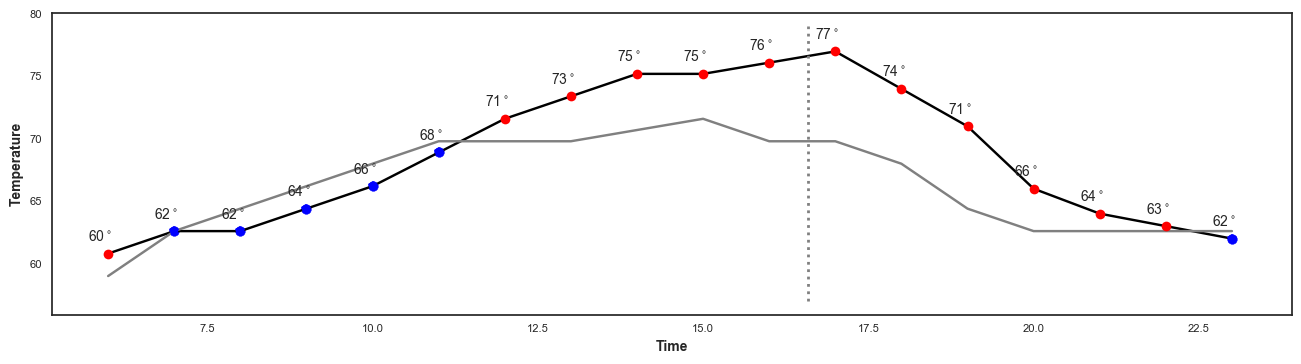

In [8]:
plt.style.use('seaborn-white')

plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12


# Set an aspect ratio
width, height = plt.figaspect(.25)
fig, ax = plt.subplots(figsize=(width,height), dpi=100)

ax.plot(longdata.loc[longdata['day'] == current_day, 'hour'], longdata.loc[longdata['day'] == current_day, 'temp'], color="black")
ax.plot(longdata.loc[longdata['day'] == yesterday_day, 'hour'], longdata.loc[longdata['day'] == yesterday_day, 'temp'], color="gray")

ax.plot(longdata.loc[longdata['color'] == 'red', 'hour'], longdata.loc[longdata['color'] == 'red', 'temp'], 'ro')
ax.plot(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'], 'bp')


plt.plot([current_hour + current_minute, current_hour + current_minute], [alldata.temp.min()-2, alldata.temp.max()+2] , linewidth=2, linestyle=":", color="gray")
plt.scatter(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'], c="blue")


plt.xlabel('Time')
plt.ylabel('Temperature')

for i, txt in enumerate(longdata.loc[longdata.day == current_day, 'temp']):
    ax.annotate(str(int(txt))+'$^\circ$', (longdata.hour[i]-.3,longdata.temp[i]+1))
    
# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('seaborn-white')




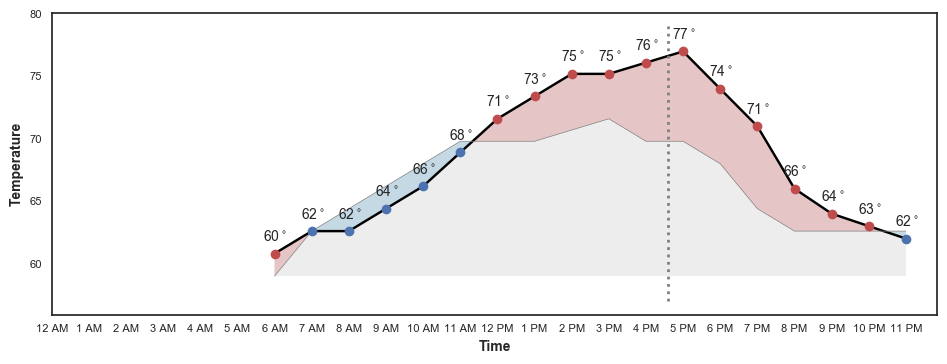

In [9]:
#Plot today vs Yesterday

import matplotlib.pyplot as plt
import numpy as np


width, height = plt.figaspect(.35)
fig, ax = plt.subplots(figsize=(width,height), dpi=100)


ax.plot(longdata.loc[longdata['day'] == current_day, 'hour'], longdata.loc[longdata['day'] == current_day, 'temp'], color="black")
ax.plot(longdata.loc[longdata['day'] == yesterday_day, 'hour'], longdata.loc[longdata['day'] == yesterday_day, 'temp'], color="gray", linewidth=0.5)

ax.plot(longdata.loc[longdata['color'] == 'red', 'hour'], longdata.loc[longdata['color'] == 'red', 'temp'], 'o', color = '#bf4c4c')
ax.plot(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'], 'o')                           


#ax.plot(longdata.loc[longdata['color'] == 'red', 'hour'], longdata.loc[longdata['color'] == 'red', 'temp'],  '*', color='#c10100')
#ax.plot(longdata.loc[longdata['color'] == 'blue', 'hour'], longdata.loc[longdata['color'] == 'blue', 'temp'],  '*', color='#90c6e4')

#Gray
ax.fill_between(longdata.loc[longdata['day'] == current_day, 'hour'], \
                longdata.loc[longdata['day'] == current_day, 'temp'], \
                min(longdata.loc[longdata['day'] == current_day, 'temp'].min(),longdata.loc[longdata['day'] == yesterday_day, 'temp'].min()), \
                where= longdata.loc[longdata['day'] == current_day, 'temp'].reset_index(drop=True) >0,\
                facecolor='#ededed', interpolate=True)


ax.fill_between(longdata.loc[longdata['day'] == current_day, 'hour'], \
                longdata.loc[longdata['day'] == current_day, 'temp'], \
                longdata.loc[longdata['day'] == yesterday_day, 'temp'], \
                where= longdata.loc[longdata['day'] == current_day, 'temp'].reset_index(drop=True) > longdata.loc[longdata['day'] == yesterday_day, 'temp'].reset_index(drop=True),\
                facecolor='#e5c5c5', interpolate=True)

ax.fill_between(longdata.loc[longdata['day'] == current_day, 'hour'], \
                longdata.loc[longdata['day'] == current_day, 'temp'], \
                longdata.loc[longdata['day'] == yesterday_day, 'temp'], \
                where= longdata.loc[longdata['day'] == current_day, 'temp'].reset_index(drop=True) < longdata.loc[longdata['day'] == yesterday_day, 'temp'].reset_index(drop=True),\
                facecolor='#c5d9e5', interpolate=True)


for i, txt in enumerate(longdata.loc[longdata.day == current_day, 'temp']):
    ax.annotate(str(int(txt))+'$^\circ$', (longdata.hour[i]-.3,longdata.temp[i]+1))
    
plt.plot([current_hour + current_minute, current_hour + current_minute], [alldata.temp.min()-2, alldata.temp.max()+2] , linewidth=2, linestyle=":", color="gray")
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.xticks(np.arange(0,24, 1.0));


labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']
ax.set_xticklabels(labels); 


In [64]:
#For plotting tomorrow: 

#Need to create color_tomorrow